# Stacked Autoencoder Model

### Loading Data

In [ ]:
import os
from skimage.feature import hog
from skimage import exposure
import numpy as np
from sklearn import svm
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Model
import cv2
from scipy import stats
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, BatchNormalization, Add, Flatten, Dense, Reshape, Conv2D, Activation
from tensorflow.keras import backend as K
# Define data augmentation settings
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy.ndimage import rotate, zoom
from skimage.transform import resize





In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Set path to your data
base_path = ''


In [ ]:
# Set random seeds for reproducibility
random_seed = 47

# Set the random seed for NumPy
np.random.seed(random_seed)

# Set the random seed for TensorFlow
tf.random.set_seed(random_seed)

In [ ]:
# Specify the list of classes (folders)
classes = ["wood"]
# "zipper", "wood", "transistor", "toothbrush", "tile", "screw", "pill", "metal_nut", , "grid", "carpet", "capsule", "cable", "bottle"

In [ ]:
def load_and_preprocess_image(image_path, target_size=(180, 180)):
    # Load the image using OpenCV
    image = cv2.imread(image_path)

    # Resize the image to the target size
    image = cv2.resize(image, target_size)

    # Normalize the pixel values to the [0, 1] range
    image = image.astype("float32") / 255.0

    return image

In [ ]:
# Initialize lists to store images and labels
images_train = []
labels_train = []

images_test = []
labels_test = []


In [ ]:
# Load and preprocess the images for the training dataset (only "good" class)
for class_name in classes:
    train_folder = os.path.join(base_path, class_name, "train", "good")

    for filename in os.listdir(train_folder):
        image_path = os.path.join(train_folder, filename)
        image = load_and_preprocess_image(image_path, target_size=(180, 180))
        images_train.append(image)
        labels_train.append(0)


In [ ]:
print('Dimension of objects in the list images_train: ', images_train[0].shape)
print('Number of samples in the list images_train: ', len(images_train))



Dimension of objects in the list images_train:  (180, 180, 3)
Number of samples in the list images_train:  247


In [ ]:
# Load and preprocess the images for the testing dataset (both "good" and "defected" classes)
for class_name in classes:
    test_folder = os.path.join(base_path, class_name, "test")

    for folder_name in os.listdir(test_folder):
        defect_folder = os.path.join(test_folder, folder_name)

        for filename in os.listdir(defect_folder):
            image_path = os.path.join(defect_folder, filename)
            image = load_and_preprocess_image(image_path, target_size=(180, 180))
            images_test.append(image)
            labels_test.append(0 if folder_name == "good" else 1)


In [ ]:
print('Dimension of objects in the list images_test: ', images_test[0].shape)
print('Number of samples in the list images_test: ', len(images_test))


Dimension of objects in the list images_test:  (180, 180, 3)
Number of samples in the list images_test:  79


In [ ]:
num_zeros = labels_test.count(0)
num_ones = labels_test.count(1)

print(f"Number of 0s in labels_test: {num_zeros}")
print(f"Number of 1s in labels_test: {num_ones}")

Number of 0s in labels_test: 19
Number of 1s in labels_test: 60


In [ ]:
# Convert the data to numpy arrays
X_train = np.array(images_train)
X_test = np.array(images_test)


In [ ]:
X_train[5].shape, X_test[0].shape

((180, 180, 3), (180, 180, 3))

# Clear Session

In [ ]:
# Clear the TensorFlow session
K.clear_session()

### Simple Stacked Autoencoder Model

In [ ]:
# Stacked Autoencoder Model
stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(256, activation="relu"),
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dense(180 * 180 * 3),
    tf.keras.layers.Reshape([180, 180, 3])
])

stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

# Set learning rate
learning_rate = 0.0001

# Compile the model with a custom optimizer that includes the learning rate
custom_optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
stacked_ae.compile(loss="mse", optimizer=custom_optimizer)



In [ ]:
# Train the stacked autoencoder with X_train as both input and output
history = stacked_ae.fit(X_train, X_train, batch_size=32, epochs=8)

Epoch 1/8
8/8 [==============================] - 8s 26ms/step - loss: 0.1561
Epoch 2/8
8/8 [==============================] - 0s 26ms/step - loss: 0.0111
Epoch 3/8
8/8 [==============================] - 0s 26ms/step - loss: 0.0041
Epoch 4/8
8/8 [==============================] - 0s 26ms/step - loss: 0.0037
Epoch 5/8
8/8 [==============================] - 0s 26ms/step - loss: 0.0036
Epoch 6/8
8/8 [==============================] - 0s 26ms/step - loss: 0.0034
Epoch 7/8
8/8 [==============================] - 0s 25ms/step - loss: 0.0034
Epoch 8/8
8/8 [==============================] - 0s 25ms/step - loss: 0.0034


### Train Data

In [ ]:
# Use the trained autoencoder to reconstruct images from X_test
reconstructed_images_train = stacked_ae.predict(X_train)

8/8 [==============================] - 0s 6ms/step


### Test Data

In [ ]:
# Use the trained autoencoder to reconstruct images from X_test
reconstructed_images = stacked_ae.predict(X_test)



3/3 [==============================] - 0s 7ms/step


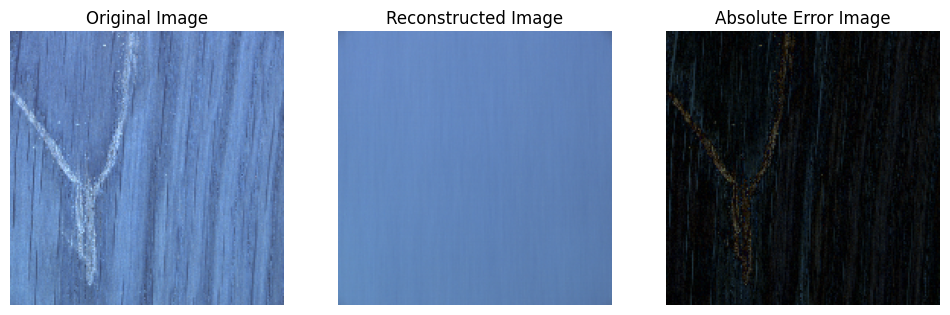

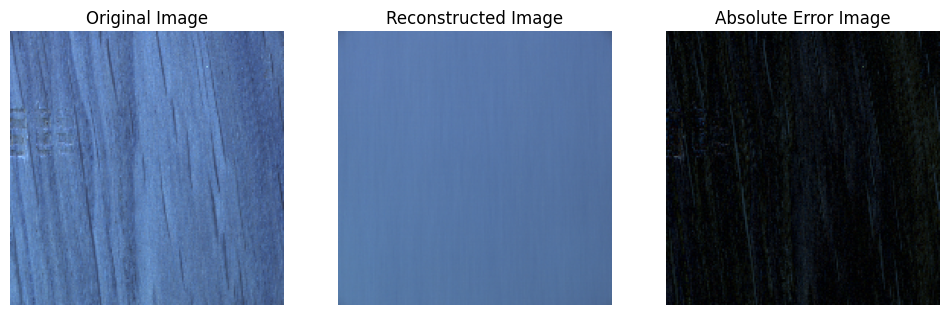

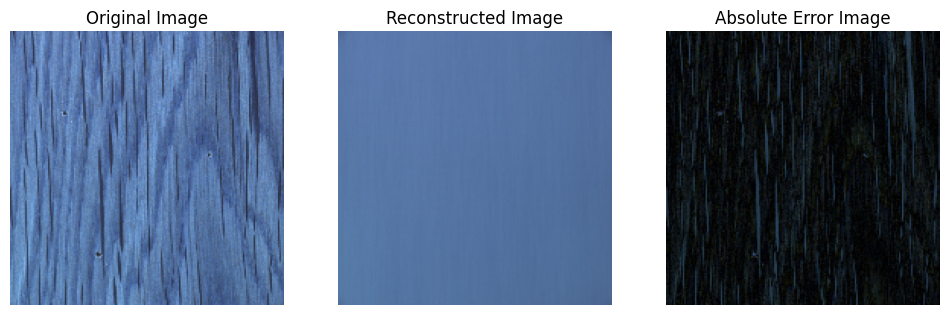

In [ ]:
import matplotlib.pyplot as plt

# Visualize a few original, reconstructed, and error images
num_samples_to_visualize = 3
random_indices = np.random.choice(len(X_test), num_samples_to_visualize)

for idx in random_indices:
    original_image = X_test[idx]
    reconstructed_image = reconstructed_images[idx]
    error_image = original_image - reconstructed_image

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(reconstructed_image)
    plt.title("Reconstructed Image")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(np.abs(error_image))
    plt.title("Absolute Error Image")
    plt.axis('off')

    plt.show()


In [ ]:
reconstructed_images[0].shape

(180, 180, 3)

In [ ]:
# Flatten the images before calculating MSE
flattened_X_test = X_test.reshape(len(X_test), -1)  # Reshape to (n_samples, height * width * channels)
flattened_reconstructed_images = reconstructed_images.reshape(len(X_test), -1)


In [ ]:
absolute_diff_vectors = [np.abs(flattened_X_test[i] - flattened_reconstructed_images[i]) for i in range(len(X_test))]


In [ ]:
absolute_diff_vectors[0].shape

(97200,)

In [ ]:
flattened_X_test.shape

(79, 97200)

In [ ]:
# Calculate the mean and standard deviation of the absolute difference vectors
mean_absolute_diff = np.mean(absolute_diff_vectors)
std_absolute_diff = np.std(absolute_diff_vectors)

# Define a threshold based on standard deviations (e.g., 3 standard deviations)
std_threshold = mean_absolute_diff + 5.8 * std_absolute_diff

In [ ]:
# Identify outliers based on the threshold
defected_image_indices = [i for i, diff_vector in enumerate(absolute_diff_vectors) if np.max(diff_vector) > std_threshold]


In [ ]:
predicted_labels = [1 if i in defected_image_indices else 0 for i in range(len(X_test))]

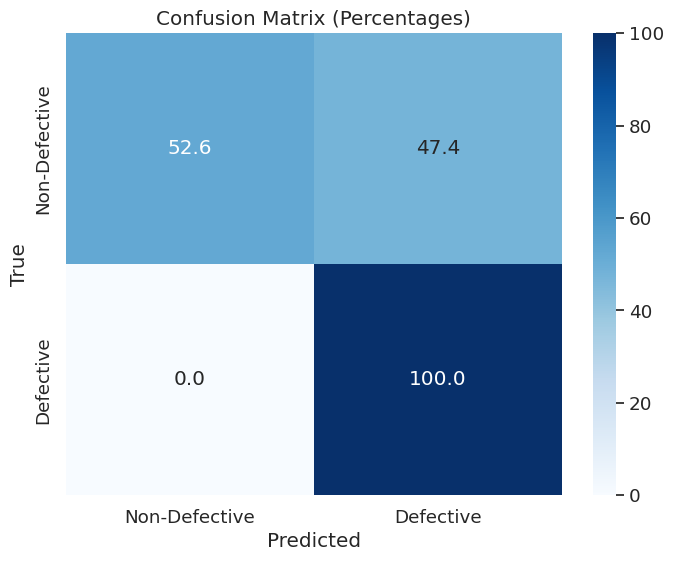

Confusion Matrix:
[[10  9]
 [ 0 60]]
True Positives (TP): 60
False Positives (FP): 9
True Negatives (TN): 10
False Negatives (FN): 0
Precision: 0.870
Accuracy: 0.886
Recall: 1.000
F1-Score: 0.930


In [ ]:
# Create the confusion matrix
confusion_mat = confusion_matrix(labels_test, predicted_labels)

# Calculate TP, FP, TN, FN values
TP = confusion_mat[1, 1]
FP = confusion_mat[0, 1]
TN = confusion_mat[0, 0]
FN = confusion_mat[1, 0]

# Calculate precision, recall, and F1-score
precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / (TP + FP + TN + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Create a confusion matrix plot (percentages)
cm_percentage = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm_percentage, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=["Non-Defective", "Defective"],
            yticklabels=["Non-Defective", "Defective"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Percentages)')
plt.show()

# Print confusion matrix and metrics
print("Confusion Matrix:")
print(confusion_mat)
print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")
print(f"Precision: {precision:.3f}")
print(f"Accuracy: {accuracy:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1_score:.3f}")


In [ ]:
# Initialize variables to track the best coefficient and best evaluation metric score
best_i = None
best_metric_score = 0.0  # Initialize with a low value
best_threshold = None
best_defected_indices = None

# Define a range of i values to search
#i_range = range(3, 9)  # Adjust the range as needed
i_range = [i / 10 for i in range(10, 151, 2)]

for i in i_range:
    # Calculate the threshold based on the current i value
    #std_threshold = mean_absolute_diff + i * std_absolute_diff
    std_threshold = mean_absolute_diff + i * std_absolute_diff

    # Identify outliers based on the threshold
    defected_image_indices = [i for i, diff_vector in enumerate(absolute_diff_vectors) if np.max(diff_vector) > std_threshold]

    # Create predicted labels (0 for non-defected and 1 for defected)
    predicted_labels = [1 if i in defected_image_indices else 0 for i in range(len(X_test))]

    # Calculate accuracy using binary labels

    accuracy = accuracy_score(labels_test, predicted_labels)

    # Calculate the confusion matrix
    cm = confusion_matrix(labels_test, predicted_labels)
    tn, fp, fn, tp = cm.ravel()

    # Check if both TP and TN are greater than 50% and accuracy is better
    if (tp / num_ones > 0.4) and (tn / num_zeros > 0.4) and accuracy > best_metric_score:
        best_i = i
        best_metric_score = accuracy
        best_threshold = std_threshold
        best_defected_indices = defected_image_indices

print(f"Best i: {best_i}")
print(f"Best Threshold: {best_threshold}")
print(f"Best Accuracy Score: {best_metric_score}")


Best i: 5.8
Best Threshold: 0.28935891315340995
Best Accuracy Score: 0.8860759493670886


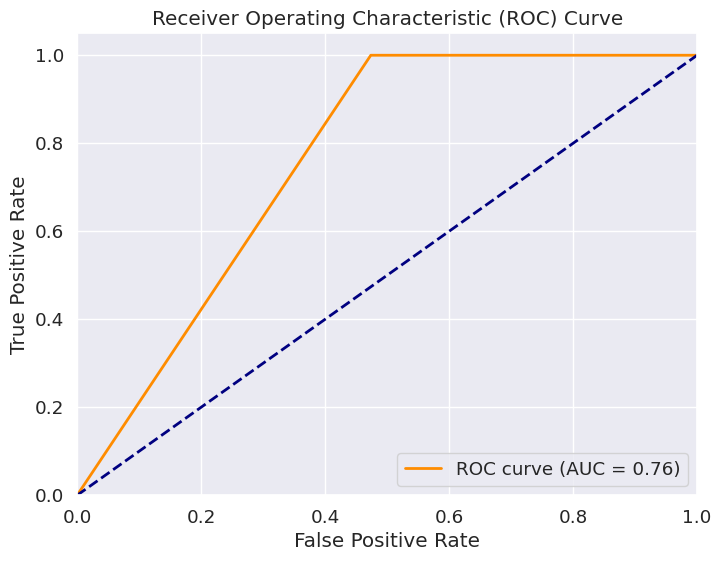

In [ ]:
fpr, tpr, thresholds = roc_curve(labels_test, predicted_labels)
roc_auc = roc_auc_score(labels_test, predicted_labels)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Complex Stacked Autoencoder

In [ ]:
# Stacked Autoencoder for Color Images
stacked_encoder_com = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(180, 180, 3)),  # Input shape for color images
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D((2, 2), padding="same"),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D((2, 2), padding="same"),
    tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D((2, 2), padding="same"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(8, activation="relu"),
])

stacked_decoder_com = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(8,)),  # Decoder input shape
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(180 * 180 * 3),
    tf.keras.layers.Reshape([180, 180, 3])

])

stacked_ae_com = tf.keras.Sequential([stacked_encoder_com, stacked_decoder_com])
stacked_ae_com.compile(loss="mse", optimizer="nadam")


In [ ]:
history_com = stacked_ae_com.fit(X_train, X_train, epochs=10)

Epoch 1/10
8/8 [==============================] - 11s 47ms/step - loss: 0.1639
Epoch 2/10
8/8 [==============================] - 0s 22ms/step - loss: 0.0134
Epoch 3/10
8/8 [==============================] - 0s 21ms/step - loss: 0.0035
Epoch 4/10
8/8 [==============================] - 0s 21ms/step - loss: 0.0035
Epoch 5/10
8/8 [==============================] - 0s 23ms/step - loss: 0.0035
Epoch 6/10
8/8 [==============================] - 0s 22ms/step - loss: 0.0035
Epoch 7/10
8/8 [==============================] - 0s 22ms/step - loss: 0.0035
Epoch 8/10
8/8 [==============================] - 0s 22ms/step - loss: 0.0035
Epoch 9/10
8/8 [==============================] - 0s 21ms/step - loss: 0.0035
Epoch 10/10
8/8 [==============================] - 0s 21ms/step - loss: 0.0035


In [ ]:
# Use the trained autoencoder to reconstruct images from X_test
reconstructed_images_com = stacked_ae_com.predict(X_test)


3/3 [==============================] - 0s 36ms/step


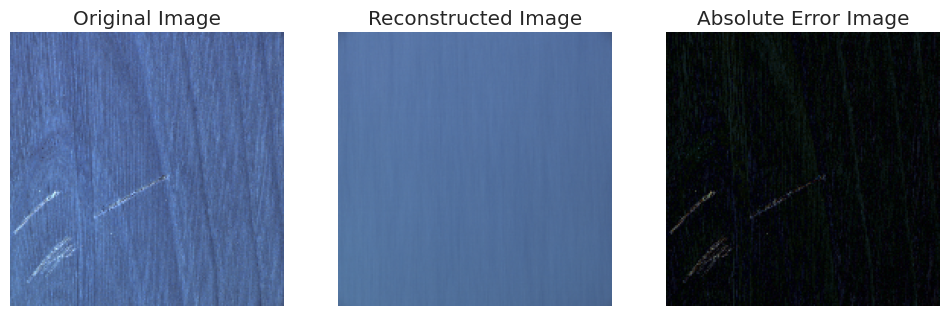

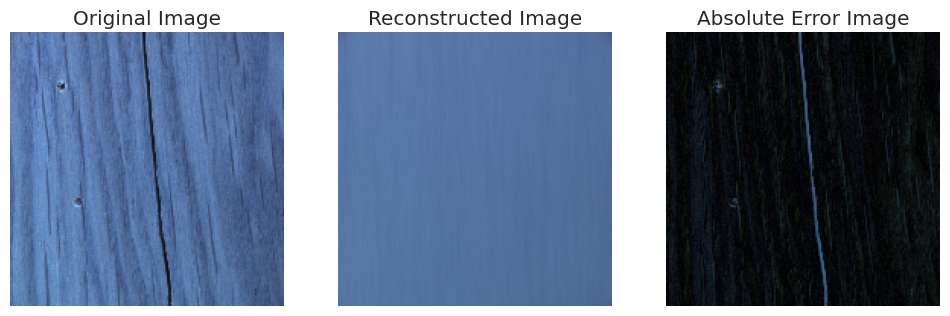

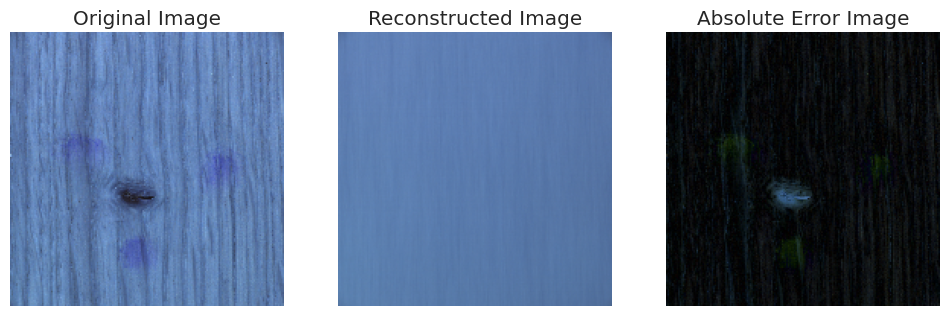

In [ ]:
# Visualize a few original, reconstructed, and error images
num_samples_to_visualize_com = 3
random_indices_com = np.random.choice(len(X_test), num_samples_to_visualize_com)

for idx_com in random_indices_com:
    original_image_com = X_test[idx_com]
    reconstructed_image_com = reconstructed_images_com[idx_com]
    error_image_com = original_image_com - reconstructed_image_com

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image_com)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(reconstructed_image_com)
    plt.title("Reconstructed Image")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(np.abs(error_image_com))
    plt.title("Absolute Error Image")
    plt.axis('off')

    plt.show()


In [ ]:
reconstructed_images_com[0].shape

(180, 180, 3)

In [ ]:
# Flatten the images before calculating MSE
flattened_reconstructed_images_com = reconstructed_images_com.reshape(len(X_test), -1)

In [ ]:
absolute_diff_vectors_com = [np.abs(flattened_X_test[i] - flattened_reconstructed_images_com[i]) for i in range(len(X_test))]

In [ ]:
absolute_diff_vectors_com[0].shape

(97200,)

In [ ]:
# Calculate the mean and standard deviation of the absolute difference vectors
mean_absolute_diff_com = np.mean(absolute_diff_vectors_com)
std_absolute_diff_com = np.std(absolute_diff_vectors_com)

# Define a threshold based on standard deviations (e.g., 3 standard deviations)
std_threshold_com = mean_absolute_diff_com + 5.8 * std_absolute_diff_com

In [ ]:
# Identify outliers based on the threshold
defected_image_indices_com = [i for i, diff_vector_com in enumerate(absolute_diff_vectors_com) if np.max(diff_vector_com) > std_threshold_com]

In [ ]:
predicted_labels_com_main = [1 if i in defected_image_indices_com else 0 for i in range(len(X_test))]

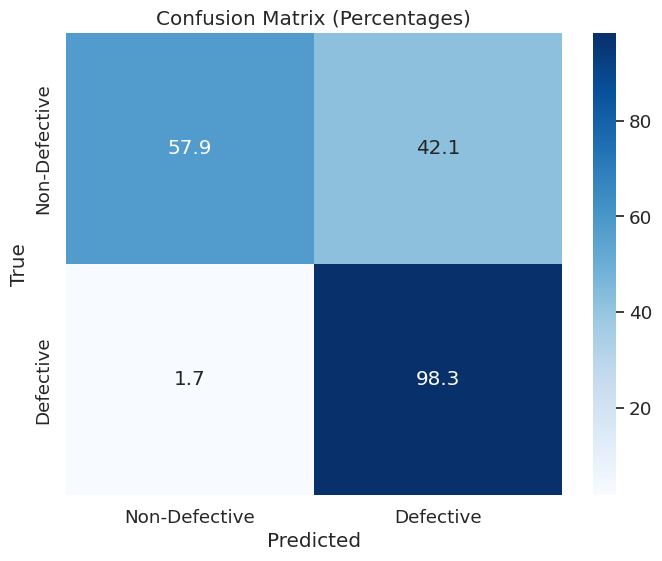

Confusion Matrix:
[[11  8]
 [ 1 59]]
True Positives (TP): 59
False Positives (FP): 8
True Negatives (TN): 11
False Negatives (FN): 1
Precision: 0.881
Accuracy: 0.886
Recall: 0.983
F1-Score: 0.929


In [ ]:
# Create the confusion matrix
confusion_mat_com = confusion_matrix(labels_test, predicted_labels_com_main)

# Calculate TP, FP, TN, FN values
TP_com = confusion_mat_com[1, 1]
FP_com = confusion_mat_com[0, 1]
TN_com = confusion_mat_com[0, 0]
FN_com = confusion_mat_com[1, 0]

# Calculate precision, recall, and F1-score
precision_com = TP_com / (TP_com + FP_com)
recall_com = TP_com / (TP_com + FN_com)
accuracy_com = (TP_com + TN_com) / (TP_com + FP_com + TN_com + FN_com)
f1_score_com = 2 * (precision_com * recall_com) / (precision_com + recall_com)

# Create a confusion matrix plot (percentages)
cm_percentage_com = confusion_mat_com.astype('float') / confusion_mat_com.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm_percentage_com, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=["Non-Defective", "Defective"],
            yticklabels=["Non-Defective", "Defective"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Percentages)')
plt.show()

# Print confusion matrix and metrics
print("Confusion Matrix:")
print(confusion_mat_com)
print(f"True Positives (TP): {TP_com}")
print(f"False Positives (FP): {FP_com}")
print(f"True Negatives (TN): {TN_com}")
print(f"False Negatives (FN): {FN_com}")
print(f"Precision: {precision_com:.3f}")
print(f"Accuracy: {accuracy_com:.3f}")
print(f"Recall: {recall_com:.3f}")
print(f"F1-Score: {f1_score_com:.3f}")


In [ ]:
# Initialize variables to track the best coefficient and best evaluation metric score
best_i_com = None
best_metric_score_com = 0.0  # Initialize with a low value
best_threshold_com = None
best_defected_indices_com = None

# Define a range of i values to search
#i_range = range(1, 10)  # Adjust the range as needed
i_range_com = [i / 10 for i in range(10, 151, 2)]

for i_com in i_range_com:
    # Calculate the threshold based on the current i value
    std_threshold_com = mean_absolute_diff_com + i_com * std_absolute_diff_com


    # Identify outliers based on the threshold
    defected_image_indices_com = [i for i, diff_vector_com in enumerate(absolute_diff_vectors_com) if np.max(diff_vector_com) > std_threshold_com]

    # Create predicted labels (0 for non-defected and 1 for defected)
    predicted_labels_com = [1 if i in defected_image_indices_com else 0 for i in range(len(X_test))]

    # Calculate accuracy using binary labels

    accuracy_com = accuracy_score(labels_test, predicted_labels_com)

    # Calculate the confusion matrix
    cm_com = confusion_matrix(labels_test, predicted_labels_com)
    tn_com, fp_com, fn_com, tp_com = cm_com.ravel()

    # Check if both TP and TN are greater than 50% and accuracy is better
    if (tp_com / num_ones > 0.5) and (tn_com / num_zeros > 0.5) and accuracy_com > best_metric_score_com:
        best_i_com = i_com
        best_metric_score_com = accuracy_com
        best_threshold_com = std_threshold_com
        best_defected_indices_com = defected_image_indices_com

print(f"Best i: {best_i_com}")
print(f"Best Threshold: {best_threshold_com}")
print(f"Best Accuracy Score: {best_metric_score_com}")


Best i: 5.8
Best Threshold: 0.29135313332080837
Best Accuracy Score: 0.8860759493670886


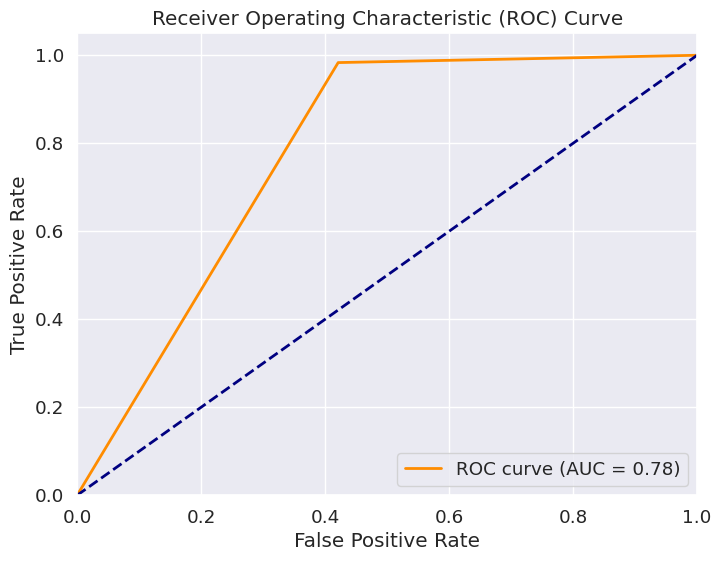

In [ ]:
fpr, tpr, thresholds = roc_curve(labels_test, predicted_labels_com_main)
roc_auc_com = roc_auc_score(labels_test, predicted_labels_com_main)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_com:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()